In [216]:
import pickle
import random
import numpy as np
import csv
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten
import tensorflow as tf
from sklearn.utils import shuffle
import os
import cv2

In [217]:
training_file = "product.pickle"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train,y_train = train['images'],train['labels']
X_valid, y_valid = X_train[0],y_train[0]


1


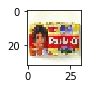

In [218]:
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

In [219]:
##NORMALIZATION##

def normalize_data(data):
    data_norm = (data - data.mean()) / (np.max(data) - np.min(data))
    return data_norm

X_train=np.asarray(X_train,dtype=np.uint8)
y_train=np.asarray(y_train,dtype=np.uint8)
X_valid = np.asarray(y_valid,dtype=np.uint8)
y_valid=np.asarray(y_valid,dtype=np.uint8)

In [220]:
def gray(X_train):
    X_gray = 0.299*X_train[:,:,:,0] + 0.587*X_train[:,:,:,1] + 0.114*X_train[:,:,:,2]
    X_gray = X_gray.reshape(X_gray.shape + (1,))
    X_gray = (X_gray - 128.0) / 128.0
    return X_gray
    
X_train = gray(X_train)

In [221]:
def productClassifier(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # : Activation and dropout
    conv1=tf.nn.dropout(tf.nn.relu(conv1), keep_prob)

    # : Pooling. Input = 28x28x16. Output = 14x14x16.
    #conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1= tf.nn.dropout(tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'), keep_prob)
    
    
    # : Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # : Activation.and dropout
    
    conv2=tf.nn.dropout(tf.nn.relu(conv2), keep_prob)
    
    # : Pooling. Input = 10x10x32. Output = 5x5x32.
    #conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'), keep_prob)
    
    # : Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # : Layer 3: Fully Connected. Input = 800. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # : Activation and dropout
    #fc1    = tf.nn.relu(fc1)
    fc1    =tf.nn.dropout(tf.nn.relu(fc1), keep_prob)

    # : Layer 4: Fully Connected. Input = 240. Output = 140.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 140), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(140))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    

    # : Activation and dropout
    #fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(tf.nn.relu(fc2), keep_prob)

    # : Layer 5: Fully Connected. Input = 140. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(140, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [222]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [223]:
X_train, y_train = shuffle(X_train, y_train)


EPOCHS = 1
BATCH_SIZE = 1

##TRAINING PIPELINE
rate = 0.001

logits = productClassifier(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [227]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    print(X_data,y_data)
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss=0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        print(X_data, y_data)
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_operation], feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss / num_examples

In [232]:

###TRAINING THE MODEL...

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    loss_history = {"train":[],"valid":[]}
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.8})
            
        #validation_accuracy = evaluate(X_valid, y_valid)
#         (validation_accuracy, validation_loss) = evaluate(X_valid, y_valid)
        (training_accuracy, training_loss) = evaluate(X_train, y_train)
#         loss_history["valid"].append(validation_loss)
        loss_history["train"].append(training_loss)
        
        
        print("EPOCH {} ...".format(i+1))
#         print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

[[[[ 0.94632812]
   [ 0.96925781]
   [ 0.97945312]
   ..., 
   [ 0.97716406]
   [ 0.97716406]
   [ 0.97071094]]

  [[ 0.98301562]
   [ 0.96939062]
   [ 0.95678906]
   ..., 
   [ 0.95329687]
   [ 0.97669531]
   [ 0.97449219]]

  [[ 0.95397656]
   [ 0.98417188]
   [ 0.97971875]
   ..., 
   [ 0.97397656]
   [ 0.96765625]
   [ 0.97560156]]

  ..., 
  [[ 0.96925781]
   [ 0.9555    ]
   [ 0.97842969]
   ..., 
   [ 0.98339844]
   [ 0.98417188]
   [ 0.96175781]]

  [[ 0.97842969]
   [ 0.97842969]
   [ 0.97842969]
   ..., 
   [ 0.98067969]
   [ 0.97478125]
   [ 0.98539844]]

  [[ 0.98284375]
   [ 0.98161719]
   [ 0.97894531]
   ..., 
   [ 0.97945312]
   [ 0.9765625 ]
   [ 0.98517969]]]


 [[[ 0.97834375]
   [ 0.98314844]
   [ 0.9815    ]
   ..., 
   [ 0.95371875]
   [ 0.96925781]
   [ 0.98760156]]

  [[ 0.98301562]
   [ 0.97609375]
   [ 0.98517969]
   ..., 
   [ 0.98225781]
   [ 0.9743125 ]
   [ 0.97834375]]

  [[ 0.96952344]
   [ 0.98067969]
   [ 0.97583594]
   ..., 
   [ 0.971148

Model saved
